*January 23, 2019*

**Financial Model Documentation:**\
A Discussion of Model Parameters with Examples

# Financial Modeling: Recommendations for mVSO

* Ensure that mVSO contains the same financial calculations that up until now only live in an Excel financial model - use the discounted cash flow method

    mVSO is already doing most of the work wrt the DCF method it is only missing discount factors

**Because we are not exposing mVSO to the financial impacts of the solution we cannot ensure the benefits (or lack thereof) that mVSO is calculating will be congruent with those calculated in the excel financial model. This was not the intended use for mVSO.**

Once the mVSO model is discounting cash flows it will automatically be capable of calculating NPV, IRR, payback as in any excel proforma thus allowing for mVSO to be the central source of the full solution and associated financial benefits/metrics.


The remaining recommendation stem from the first:

* Optimize for highest NPV - this will be the most straight forward, obvious financial Objective function that we can write. We can't write an Objective function for IRR so we cant optimize for IRR 
* Allow users to provide a hurdle rate/WACC/Cost of Equity and target IRR as a constraint
* Do not optimize for least payback it is not a meaningful metric and will produce irrelevant results (poor IRR, low NPV) that will ultimately not be considered for investment

# Financial Model Documentation and Process

The Discounted Cash Flow method is described in detail in this document with supporting examples and visualizations.

The basis of the calculations in this document were gleaned from the following resources:

https://corporatefinanceinstitute.com/resources/knowledge/valuation/dcf-formula-guide/
https://corporatefinanceinstitute.com/resources/knowledge/valuation/net-present-value-npv/
https://corporatefinanceinstitute.com/resources/knowledge/valuation/cash-flow-guide-ebitda-cf-fcf-fcff/
https://corporatefinanceinstitute.com/resources/knowledge/valuation/free-cash-flow-to-equity-fcfe/
https://corporatefinanceinstitute.com/resources/knowledge/finance/internal-rate-return-irr/
https://corporatefinanceinstitute.com/resources/knowledge/finance/what-is-wacc-formula/
https://hbr.org/2014/11/a-refresher-on-net-present-value
https://hbr.org/2012/07/do-you-know-your-cost-of-capital

The following resources are from authoritative figures in the energy industry who have discussed the DCF/NPV method

https://www.seia.org/research-resources/valuation-solar-generation-assets \
https://blog.aurorasolar.com/quantifying-the-value-of-a-solar-installation/ \
https://www.nrel.gov/analysis/crest.html



All of these resources were used to establish a common framework for calculating cashflows and for understanding the nuances inherent in these calculations and concepts in finance and for common vernacular.

Once the mechanics of the cash flow logic were established the python model was tested against the National Renewable Energy Laboratories (NREL) Cost of Renewable Energy Spreadsheet Tool (CREST). The goal here was to test the accuracy of the python DCF model to the CREST model WITHOUT any major alterations and by using the same parameters and definitions, calculations. The test was successful. By only rearranging a couple of terms I was able to reproduce the same results as the CREST model.

This model doesnt include the tax credits yet as the main goal of this document is to illustrate the cash flow process for mVSO software. We can easily add incentives or other financial model parameters as we see fit.

# Whats Covered Next

In the sections that follow I will define

The model inputs
* Technical Parameters
* Economic Parameters
* Financial Parameters

In the **Financial Model** Section I define and calculate the following model parameters
* Revenue
* OPEX
* CAPEX/Equity/Debt
* Depreciation
* Debt Service
* Taxes

In the **Cash Flow** section we use the model parameters above and calculate
* EBITDA
* EBTDA
* EBIT
* Free Cash Flow
* Free Cash Flow to Equity

In the **Discounted Cash Flow** section I calculate the discount factors and use them to discount certain cashflows

In the **IRR** section I calculate the running IRR for the pre-tax and after-tax cash flow to equity

In the **DataFrame/Table** the inputs and outputs are stored in tables and then displayed

Finally a couple of familiar plots are generated showing cashflow and IRR over time.

All of the tables and plots are exported to Excel.

In [2]:
import requests
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import datetime as dtm

#### Technical Parameters
These are the technology specific parameters and/or constraints

In [3]:
pv_capacity_kw = 1000
capacity_factor = 0.15
pv_degradation_rate = -0.005

#### Economic Parameters
These describe the cost associated with a technology

In [4]:
project_life = 20
pv_unit_cost_kw = 1800
om_rate = 6.5
om_escalation_rate = 0.016
inverter_repl_rate = 0
inverter_repl_year = 0
util_escalation_rate = 0.0
average_energy_rate = 0.1885

#### Financial Parameters
These describe the financial modeling inputs

In [5]:
percent_debt = 0.45
percent_equity = 1-percent_debt
cost_equity = .12
cost_of_debt = 0.07
corporate_tax_rate = 0.21
state_tax_rate = 0.085
inflation_rate = 0.0
bonus_depreciation = 1.0
itc_rate = 0.26
debt_term = 10
payments_per_year = 1
effective_tax_rate = corporate_tax_rate+(state_tax_rate*(1-corporate_tax_rate))
wacc = percent_debt*cost_of_debt*(1-effective_tax_rate) + percent_equity*cost_equity
years = list(range(project_life))

# Financial Model

If you see `this` type of highlight I am refering to code.

# Generation
In lieu of leveraging a solar modeling tool like PVLib I am estimating solar generation via the capacity factor method.

$$kW_{solar}*CF*8760$$

$kW_{solar}$ = DC capacity of solar PV\
$CF$ = Capacity factor\
$8760$ = number hours per year

The code snippet below produces a Pandas Series that is 21 elements long. The first year of generation is stored in element 1 of the Series. The Series is than populated with the ensuing years generation by degrading the PV generation stored in element 1 of the Series. The process described here is repeated for all other components in the cash flow sections unless otherwise noted.

In [6]:
yr1_generation = pv_capacity_kw*capacity_factor*8760
pv_generation = pd.Series(index=years)
pv_generation[1] = yr1_generation 
for year in range(1, project_life):
    pv_generation[year+1] = pv_generation[year] * (1 + pv_degradation_rate)
pv_generation = pv_generation.fillna(value=0)

# Rate Escalation
For simplification I assume a flat rate that is escalated each year.

In [7]:
rate = pd.Series(index=years)
rate[1] = average_energy_rate
for year in range(1, project_life):
    rate[year+1] = rate[year] * (1 + util_escalation_rate)
rate = rate.fillna(value=0)

# Revenue

**Revenue** is all positive inflows of cash to the project from operation of the energy assets. It will contain at least one but possibly all of the following

- Utility avoided cost (AVC)
- Net energy metering credits
- Ancillary service payments
- etc.

Cash Flow Model Parameter/s:

`revenue`

In [8]:
revenue = pv_generation*rate

# Operating Expenses

**Operating Expenses (OPEX)** For a given project there are actually a number of operating expenses that need to be accounted for. This model (in its current state) accounts for fixed cost O&M expense as well a single inverter replacement that occurs at the replacement year, year 16 in this case. The replacement cost (`replacement`) and O&M expenses (`om`) are rolled into a model component called `opex`.

As more OPEX line items are required they can be can be rolled up into the `opex` component. For instance if we wanted to add an annual software license expense line item, we can call it `software_license` and define its value however we want over the project lifetime and then add it along with `om` and `replacement` to `opex`.

Cash Flow Model Parameter/s:

`opex`

In [9]:
#Replacement Cost
replacement_cost = inverter_repl_rate * pv_capacity_kw
replacement = pd.Series(index=years)
replacement[inverter_repl_year] = replacement_cost
for year in range(1, project_life):
    replacement[year+1] = replacement[year]
replacement = replacement.fillna(value=0)

# O&M Expenses (fixed O&M)
om_cost = om_rate*pv_capacity_kw
om = pd.Series(index=years)
om[1] = om_cost
for year in range(1, project_life):
    om[year+1] = om[year] * (1 + om_escalation_rate)
om = om.fillna(value=0)

opex = om + replacement

# Capital Expense, Debt/Equity Share of CAPEX

**Capital Expenses (CAPEX)** 
- Power capacity based pricing, \\$/kW, for energy generating technologies and \\$/kWh of installed storage capacity

**Debt/Equity Share of CAPEX**

The share of equity and debt is calculated based on the debt to equity gearing ratio which is called `percent_debt` and `percent_equity` in this model. The equity portion of the investment is the amount left over after the debt share and represented in the model as a single dollar value in year 0.

The debt portion of the investments shows up as interest and principal payments via the debt service calculations below.

Cash Flow Model Parameters/s:

`equity`\
`debt share`\
`capex`

In [10]:
# First calculate the total cost of the project
pv_cost=pv_capacity_kw*pv_unit_cost_kw

# Then split that total cost between the debt and equity according to the percent debt/equity inputs
debt_share = pv_cost*percent_debt
equity_share = pv_cost*percent_equity

# I do use equity in the model

equity = pd.Series(index=years)
equity[0] = equity_share
for year in range(1, project_life):
    equity[year+1] = equity[year] * 0
equity=equity.fillna(value=0)

# I actually do not use capex in the model but leaving it here for now
capex = pd.Series(index=years)
capex[0] = pv_cost
for year in range(1, project_life):
    capex[year+1] = capex[year] * 0
capex=capex.fillna(value=0)    

# Depreciation

**Depreciation**

Federal: Modified Acceleration Cost Recovery System (MACRS) @ Federal corporate tax rate\
State: 10 year straight line depreciation @ State tax rate

The 5 year MACRS depreciation schedule is used in this example so we can see it across multiple years, as opposed to 100% depreciation year one. Currently State depreciation is not considered but is a relatively simple addition to the model.

The basis for the depreciation expense is the full project cost (`capex`) multiplied by one minus half of the current ITC rate.

Cash Flow Model Parameter/s:

`depreciation`

In [11]:
basis = (1-0.5*itc_rate)*pv_cost
macrs_sched = pd.Series(index=years)
for year in range(1, project_life):
    macrs_sched[year+1] = macrs_sched[year] * 0
macrs_sched[1] = 0.2000
macrs_sched[2] = 0.3200
macrs_sched[3] = 0.1920
macrs_sched[4] = 0.1152
macrs_sched[5] = 0.1152
macrs_sched[6] = 0.0576
macrs_sched = macrs_sched*basis

depreciation = macrs_sched.fillna(value=0)

# Debt Service

**Debt Service**

When funded in whole or in part by debt this section of code will calculate principal and interest payments based on the amount financed (`percent_debt`), `cost_of_debt`, length of debt term (`debt_term`), number of payments per year (`payments_ per_year`).

A standard amortization method is used here and is no different from using excel *pmt* and *ipmt* functions.

From this we get interest payments and principal payments.

Cash Flow Model Parameter/s:

`interest`\
`principal`

In [12]:
def loan_calc(principal, rate, payment):
    """
    Generator that yields successive period payment details
    """
    amount = payment
    while principal > 0:
        period_interest = principal * rate
        principal_reduction = min(principal, amount - period_interest)
        principal = principal - principal_reduction
        yield principal_reduction, period_interest, principal
        
def amortization_table(interest_rate, project_life, loan_years, payments_year, principal):
    """
    Calculate the amortization schedule given the loan details


    :param interest_rate: The annual interest rate for this loan
    :param years: Number of years for the loan
    :param payments_year: Number of payments in a year
    :parma principal: Amount borrowed

    :return: 
        schedule: Amortization schedule as a pandas dataframe
    """
    #Calculate the fixed payment 
    period_rate = interest_rate/payments_year
    payment = -1 * np.pmt(period_rate, loan_years*payments_year, principal)

    #Generate the period details schedule

    df = pd.DataFrame(list(loan_calc(principal, period_rate, payment)), columns=["Principal", "Interest", "Balance"])
    df["Total Payment"] = df["Principal"] + df["Interest"]
    df["Cumulative Principal"] = df["Principal"].cumsum()
    
    index = np.arange(1, (project_life)*payments_year)
    df2 = pd.DataFrame(index=index) 
    df = pd.concat([df,df2], axis=1).fillna(value=0)
    new_row = pd.DataFrame({'Principal':0, 'Interest':0, 'Balance':0, 'Total Payment':0, 'Cumulative Principal':0}, index=[0])
    df = pd.concat([new_row,df]).reset_index(drop=True)
    df=df.round(2)
    return(df)

In the cell below I call the function that calculates the principal and debt payments via the function `amortization_table`. I then create the `interest` and `principal` parameters which are used in the cash flows.

In [13]:
debt_service_df = amortization_table(cost_of_debt, project_life, debt_term, payments_per_year, debt_share)

interest = debt_service_df['Interest']
principal = debt_service_df['Principal']

# Tax

**Taxes**

Taxable income is defined as `revenue - opex - interest - depreciation`.

Taxes are calculated according to either the Federal and State taxes separately OR taxes may be calculated by using the Effective tax rate and we would report a single taxes line item. In this model the assumption is that State and Federal taxes will be considered separately.

Taxable income for the state is calculated by taking the taxable income and multiplying it by the state tax rate. The state tax amount owed is deducted from the federal taxable income, effectively reducing the federal taxes owed. The federal taxable income is then multiplied by the corporate tax rate to find the federal tax amount owed (or saved).

Cash Flow Model Parameter/s

`fed_tax`\
`state_tax`

In [14]:
# These are actually used in the Cash Flows below
taxable_income = revenue - opex - interest - depreciation

fed_taxable_income = taxable_income

state_taxable_income = taxable_income

state_tax = -state_taxable_income * state_tax_rate

_fed_tax = (fed_taxable_income + state_tax) * corporate_tax_rate

fed_tax = [-i for i in _fed_tax]

# Cash Flows

This section describes how to arrive at different cash flow

**EBITDA: Earnings Before Interest, Taxes, Depreciation and Amortization**

aka **Gross Profit**

CREST Terminology: **EBITDA (Operating Income)**

    EBITDA = Gross Profit = Operating Income = Revenue - OPEX

`ebitda = revenue - opex`

**EBTDA:**

CREST Terminology: **Operating Income After Interest**

    EBTDA = Operating Income After Interest = Revenue - OPEX - Interest

`ebtda = revenue - opex - interest`

**EBIT: Earnings Before Interest and Taxes.**
    
    EBIT = Revenue - OPEX - Depreciation
    
`ebit = revenue - interest - Depreciation`


**EBTE: Earnings before Tax to Equity**

    EBTE = Revenue - OPEX - Interest - Depreciation - Principal

`ebte = revenue - opex - interest - principal `

**Net EBTE: Net Earnings Before Taxes to Equity**

CREST Terminology: **Net Pre Tax Cash Flow Equity**

    Net EBTE = Revenue - OPEX - Depreciation - Interest - Principal

`net_ebte = revenue - opex - interest - principal - equity`

**FCF: Free Cash Flow**
Note that the sign of taxes are negative so I am adding. The point is we want to subtract taxes at this level in the cash flows.

    FCF = Revenue - OPEX - Interest + Fed Tax + State Tax

`free_cash_flow = revenue - opex - interest + fed_tax + state_tax`

**FCFE: Free Cash Flow to Equity** 

The so called *Levered Free Cash Flow*

    FCFE = Revenue - OPEX - Interest - principal + Fed Tax + State Tax

`free_cash_flow_equity = revenue - opex - interest - principal + fed_tax + state_tax`

**NET FCFE** At this level we are adding the equity share of the investment to FCFE

CREST Terminology: **After Tax Cash Flow to Equity**

    FCFE = Revenue - OPEX - Interest - principal + Fed Tax + State Tax - Equity

`net_free_cash_flow_equity = revenue - opex - interest - principal + fed_tax + state_tax - equity`

# Cash Flows

In [31]:
# Operating Income (CREST)
ebitda = revenue - opex

# Operating Income After Interest Expense (CREST)
ebtda = revenue - opex - interest

ebit = revenue - opex - depreciation

# Pre Tax Cash Flow Equity (CREST)
# Earnings Before Taxes to Equity
ebte = revenue - opex - interest - principal 

# Net Pre Tax Cash Flow Equity (CREST)
# Net Earnings Before Taxes to Equity
net_ebte = revenue - opex - interest - principal - equity

free_cash_flow = revenue - opex - interest + fed_tax + state_tax

free_cash_flow_equity = revenue - opex - interest - principal + fed_tax + state_tax

# After Tax Cash Flow to Equity (CREST)
net_free_cash_flow_equity = revenue - opex - interest - principal + fed_tax + state_tax - equity

**ATTENTION**

In the cash flows above we stop at ebitda in mVSO. By adding the remaining cashflows we have more flexibility in our financial optimizations.

# Present Value Calculations - Discounted Cash Flow

Having calculated the cash flows in the section above we can now discount them to find the present value. We can then use those discounted cash flows to calculate the Net Present Value, IRR and Payback.

Calculate the Discount Factors

In [32]:
discount_factors = [(1/(1 + cost_equity)) ** i for i in range(0,project_life+1)]

discounted_after_tax_fcfe = discount_factors*net_free_cash_flow_equity

cumulative_after_tax_fcfe = net_free_cash_flow_equity.cumsum()
cumulative_discounted_after_tax_fcfe = discounted_after_tax_fcfe.cumsum()

In [33]:
irrs_net_ebte = [np.irr(net_ebte[0:i+1]) for i in range(0, project_life+1)]
irrs_net_fcfe = [np.irr(net_free_cash_flow_equity[0:i+1]) for i in range(0, project_life+1)]
irrs_discounted_after_tax_fcfe = [np.irr(discounted_after_tax_fcfe[0:i+1]) for i in range(0, project_life+1)]

# DataFrames/Tables

In [20]:
tech_params = pd.DataFrame(data={'PV Capacity (kWdc)': pv_capacity_kw},
                    index=['Technical Parameters'])


econ_params = pd.DataFrame(data={'Project Lifetime (yrs)': project_life,
                                'PV Unit Cost ($/kW-dc)': pv_unit_cost_kw,
                                'PV O&M Rate ($/kW-yr)': om_rate,
                                'PV O&M Escalation Rate (%)': om_escalation_rate,
                                'Inverter Replacement Cost ($/kW)': inverter_repl_rate,
                                'Inverter Replacement Year': inverter_repl_year,
                                'Utility Escalation Rate (%/yr)': util_escalation_rate},
                    index=['Economic Parameters'])

fin_params = pd.DataFrame(data={'Percent Debt': percent_debt,
                               'Percent Equity': percent_equity,
                               'Cost of Debt': cost_of_debt,
                               'Cost of Equity': cost_equity,
                               'Corporate Tax Rate': corporate_tax_rate,
                               'State Tax Rate': state_tax_rate,
                               'Inflation Rate': inflation_rate,
                               'Investment Tax Credit Rate': itc_rate,
                               'Debt Term': debt_term,
                               'Payments per Year': payments_per_year,
                               'Weighted Average Cost of Capital': wacc,
                               'Effective Tax Rate': effective_tax_rate},
                         index=['Financial Parameters'])

fin_metrics = pd.DataFrame(data={'Pre Tax Equity IRR': irrs_net_ebte[-1] ,
                                 'After Tax Equity IRR': irrs_net_fcfe[-1],
                                ' Net Present Value': discounted_after_tax_fcfe.sum().round(0)},
                           index=['Financial Metrics'] )

proforma = pd.DataFrame(data={'Delivered Energy': pv_generation,
                              'Project Revenue': revenue,
                              'Operating Expense': opex,
                              'EBITDA': ebitda,
                              'Interest': interest,
                              'Cash from Operations After Interest': ebtda,
                              'Principal': principal,
                              'Net Pre-Tax Cash Flow to Equity': net_ebte,
                              'Running IRR Pre Tax': irrs_net_ebte,
                              'Depreciation': depreciation,
                             'Federal Taxable Income': fed_taxable_income,
                             'State Taxable Income': state_taxable_income,
                             'Federal Taxes': fed_tax,
                             'State Taxes': state_tax,
                             'After-Tax Cash Flow to Equity': free_cash_flow_equity,
                             'NetAfterTaxCashFlowtoEquity': net_free_cash_flow_equity,
                             'DiscountedAfterTaxCashFlowtoEquity': discounted_after_tax_fcfe,
                             'CumulativeDiscountedAfterTaxCashFlowtoEquity': cumulative_discounted_after_tax_fcfe,
                             'Running IRR After Tax': irrs_net_fcfe,
                             'CumulativeAfterTaxCashFlowtoEquity': cumulative_after_tax_fcfe})

# Calculate Payback

In [21]:
final_full_year = proforma[proforma.CumulativeAfterTaxCashFlowtoEquity < 0].index.values.max()
fractional_yr =- proforma.CumulativeAfterTaxCashFlowtoEquity[final_full_year]/proforma.NetAfterTaxCashFlowtoEquity[final_full_year]
payback_period = final_full_year + fractional_yr
payback_period

8.37539370202936

# Display the Inputs and Outputs

In [22]:
tech_params.T

,Technical Parameters
PV Capacity (kWdc),1000


In [23]:
econ_params.T

,Economic Parameters
Project Lifetime (yrs),20.000
PV Unit Cost ($/kW-dc),1800.000
PV O&M Rate ($/kW-yr),6.500
PV O&M Escalation Rate (%),0.016
Inverter Replacement Cost ($/kW),0.000
Inverter Replacement Year,0.000
Utility Escalation Rate (%/yr),0.000


In [24]:
fin_params.T

,Financial Parameters
Percent Debt,0.45000
Percent Equity,0.55000
Cost of Debt,0.07000
Cost of Equity,0.12000
Corporate Tax Rate,0.21000
State Tax Rate,0.08500
Inflation Rate,0.00000
Investment Tax Credit Rate,0.26000
Debt Term,10.00000
Payments per Year,1.00000


In [25]:
fin_metrics.T

,Financial Metrics
Pre Tax Equity IRR,0.133521
After Tax Equity IRR,0.119909
Net Present Value,-546.000000


In [27]:
proforma

,Delivered Energy,Project Revenue,Operating Expense,EBITDA,Interest,Cash from Operations After Interest,Principal,Net Pre-Tax Cash Flow to Equity,Running IRR Pre Tax,Depreciation,Federal Taxable Income,State Taxable Income,Federal Taxes,State Taxes,After-Tax Cash Flow to Equity,NetAfterTaxCashFlowtoEquity,DiscountedAfterTaxCashFlowtoEquity,CumulativeDiscountedAfterTaxCashFlowtoEquity,Running IRR After Tax,CumulativeAfterTaxCashFlowtoEquity
0,0.000000e+00,0.000000,0.000000,0.000000,0.00,0.000000,0.00,-990000.000000,NaN,0.0,0.000000,0.000000,-0.000000,-0.000000,0.000000,-990000.000000,-990000.000000,-990000.000000,NaN,-9.900000e+05
1,1.314000e+06,247689.000000,6500.000000,241189.000000,56700.00,184489.000000,58625.78,125863.220000,-0.872865,313200.0,-128711.000000,-128711.000000,24731.818650,10940.435000,161535.473650,161535.473650,144228.101473,-845771.898527,-0.836833,-8.284645e+05
2,1.307430e+06,246450.555000,6604.000000,239846.555000,52596.20,187250.355000,62729.58,124520.775000,-0.576128,501120.0,-313869.645000,-313869.645000,60310.052287,26678.919825,211509.747112,211509.747112,168614.275440,-677157.623087,-0.449053,-6.169548e+05
3,1.300893e+06,245218.302225,6709.664000,238508.638225,48205.12,190303.518225,67120.65,123182.868225,-0.365529,300672.0,-110368.481775,-110368.481775,21207.303773,9381.320951,153771.492949,153771.492949,109451.511358,-567706.111729,-0.262071,-4.631833e+05
4,1.294388e+06,243992.210714,6817.018624,237175.192090,43506.68,193668.512090,71819.10,121849.412090,-0.230020,180403.2,13265.312090,13265.312090,-2548.929718,-1127.551528,118172.930844,118172.930844,75101.033930,-492605.077800,-0.160380,-3.450104e+05
5,1.287916e+06,242772.249660,6926.090922,235846.158738,38479.34,197366.818738,76846.43,120520.388738,-0.140708,180403.2,16963.618738,16963.618738,-3259.559341,-1441.907593,115818.921805,115818.921805,65718.766633,-426886.311167,-0.088463,-2.291914e+05
6,1.281477e+06,241558.388412,7036.908377,234521.480035,33100.09,201421.390035,82225.69,119195.700035,-0.079588,90201.6,111219.790035,111219.790035,-21370.882655,-9453.682153,88371.135227,88371.135227,44771.567320,-382114.743847,-0.047412,-1.408203e+05
7,1.275069e+06,240350.596470,7149.498911,233201.097559,27344.29,205856.807559,87981.48,117875.327559,-0.036281,0.0,205856.807559,205856.807559,-39555.385572,-17497.828643,60822.113344,60822.113344,27512.835246,-354601.908601,-0.024491,-7.999819e+04
8,1.268694e+06,239148.843488,7263.890893,231884.952594,21185.59,210699.362594,94140.19,116559.172594,-0.004671,0.0,210699.362594,210699.362594,-40485.882522,-17909.445821,58163.844251,58163.844251,23491.401168,-331110.507433,-0.006094,-2.183434e+04
9,1.262351e+06,237953.099270,7380.113148,230572.986123,14595.78,215977.206123,100730.00,115247.206123,0.018981,0.0,215977.206123,215977.206123,-41500.020156,-18358.062520,55389.123446,55389.123446,19973.873189,-311136.634244,0.008581,3.355478e+04


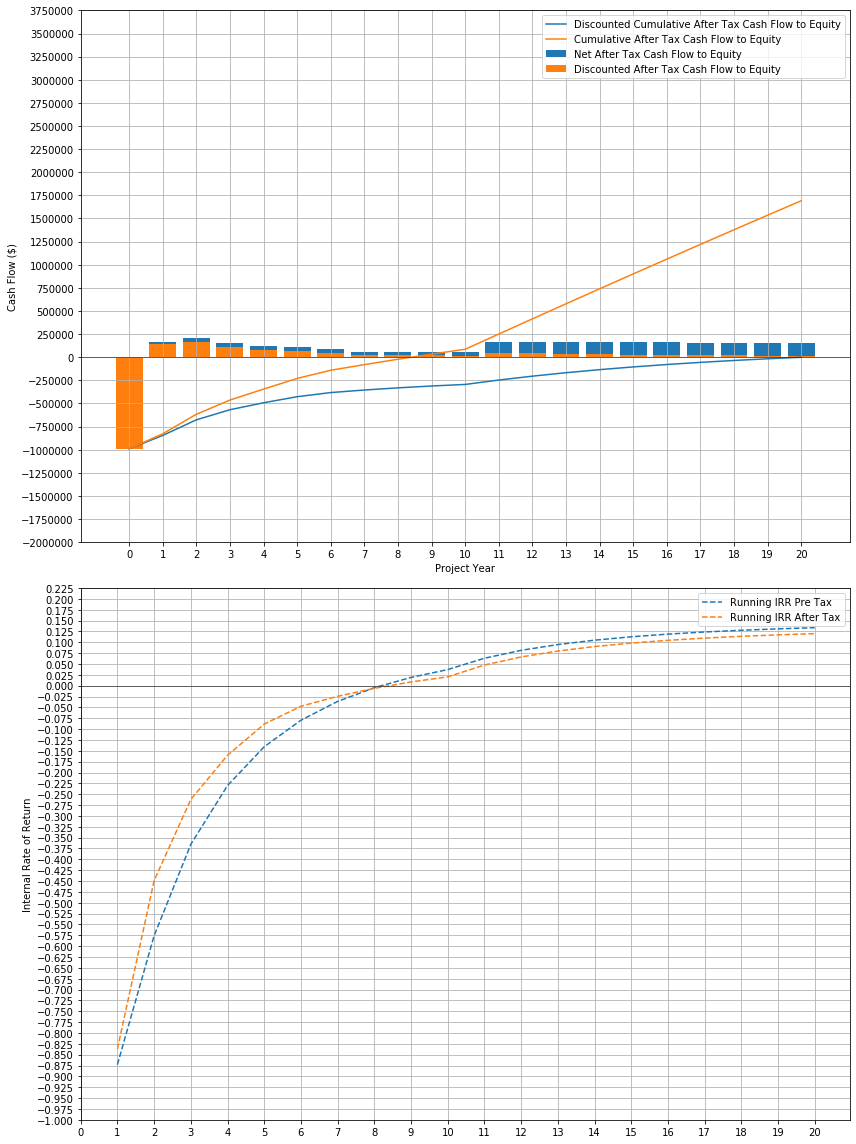

In [28]:
fig, ax = plt.subplots(2,1, figsize=(12,16))

ax[0].plot(proforma['CumulativeDiscountedAfterTaxCashFlowtoEquity'], label='Discounted Cumulative After Tax Cash Flow to Equity')
ax[0].plot(proforma['CumulativeAfterTaxCashFlowtoEquity'], label='Cumulative After Tax Cash Flow to Equity')
ax[0].bar(range(len(proforma)) , proforma['NetAfterTaxCashFlowtoEquity'], label='Net After Tax Cash Flow to Equity')
ax[0].bar(range(len(proforma)) , proforma['DiscountedAfterTaxCashFlowtoEquity'], label='Discounted After Tax Cash Flow to Equity')

ax[0].set_ylabel('Cash Flow ($)')
ax[0].set_xlabel('Project Year')
ax[0].grid(True)
ax[0].axhline(0, color='k', linewidth=0.5)
ax[0].set_xticks(np.arange(0, 21, step=1))
ax[0].set_yticks(np.arange(-2000000, 4000000, step=250000))

ax[0].legend()

ax[1].plot(proforma['Running IRR Pre Tax'], '--', label='Running IRR Pre Tax')
ax[1].plot(proforma['Running IRR After Tax'], '--', label='Running IRR After Tax')
ax[1].set_ylabel('Internal Rate of Return')
ax[1].grid(True)
ax[1].axhline(0, color='k', linewidth=0.5)
ax[1].set_yticks(np.arange(-1.0, .25, step=0.025))
ax[1].set_xticks(np.arange(0, 21, step=1))
ax[1].legend()

fig.tight_layout()
plt.show()


# Write Inputs and Outputs to Excel

In [29]:
with pd.ExcelWriter('financial_model.xlsx') as writer:
    tech_params.T.to_excel(writer, sheet_name='Parameters', startrow=0, startcol=0)
    econ_params.T.to_excel(writer, sheet_name='Parameters', startrow=0, startcol=2)
    fin_params.T.to_excel(writer, sheet_name='Parameters', startrow=0, startcol=4)
    fin_metrics.T.to_excel(writer, sheet_name='Financial Metrics')
    proforma.to_excel(writer, sheet_name='Proforma')